# 準備

## Import 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import torchvision

## Path

## def

In [2]:
def view_img(dir_name, file_name):
    
    info_table = pd.read_csv(f'../data/{dir_name}.csv', header=None, names=['name', 'label'])
    target_label = info_table[info_table['name']==f'{file_name}']['label']
    
    # # Display the image
    img = Image.open(f'../data/{dir_name}/'+file_name)
    # img = Image.open('../data/train_1/'+f'train_1811.png')
    
    plt.title(file_name)
    plt.imshow(img)
    plt.show()

    print("Label:", target_label.values[0])  # values[0] is used to get the first value if multiple rows match the condition
    print("Size of the image:", img.size)


# EDA

In [3]:
df = pd.read_csv('../data/train_1.csv', header=None, names=['name', 'label'])
df.head(3)

,name,label
0,train_0.png,1
1,train_1.png,0
2,train_2.png,0


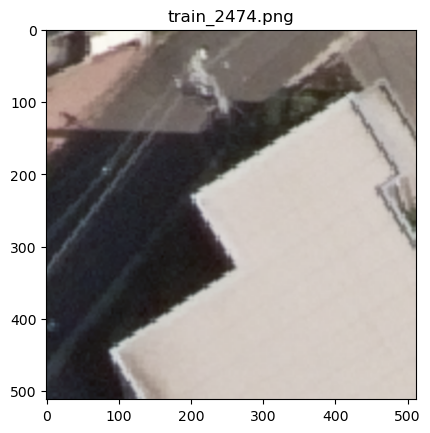

Label: 0
Size of the image: (512, 512)


In [5]:
random_idx = random.choice(range(len(df)))
file_name = f'train_{random_idx}.png'
dir_name = 'train_1'

view_img(dir_name, file_name)

In [6]:
!find ../data/train_1/ -type f -size -40k

../data/train_1/train_4093.png
../data/train_1/train_2041.png
../data/train_1/train_4639.png
../data/train_1/train_3278.png
../data/train_1/train_336.png
../data/train_1/train_2052.png
../data/train_1/train_2738.png
../data/train_1/train_3644.png
../data/train_1/train_4556.png
../data/train_1/train_2398.png
../data/train_1/train_2634.png
../data/train_1/train_641.png
../data/train_1/train_569.png
../data/train_1/train_2491.png
../data/train_1/train_2542.png
../data/train_1/train_3634.png
../data/train_1/train_1383.png
../data/train_1/train_2960.png
../data/train_1/train_606.png
../data/train_1/train_3838.png
../data/train_1/train_308.png
../data/train_1/train_4577.png
../data/train_1/train_3555.png
../data/train_1/train_3590.png
../data/train_1/train_2937.png
../data/train_1/train_4229.png
../data/train_1/train_1844.png
../data/train_1/train_4318.png
../data/train_1/train_7.png
../data/train_1/train_1811.png
../data/train_1/train_3738.png
../data/train_1/train_2712.png
../data/train_1/

In [7]:
# Directory to search
directory = "../data/train_1/"

# Maximum file size in bytes (40K in this case)
max_size = 40 * 1024

# Get list of files in the directory and subdirectories
file_list = []
for foldername, subfolders, filenames in os.walk(directory):
    for filename in filenames:
        full_path = os.path.join(foldername, filename)
        if os.path.getsize(full_path) <= max_size:
            file_list.append(full_path)


In [8]:
file_list

['../data/train_1/train_4093.png',
 '../data/train_1/train_2041.png',
 '../data/train_1/train_4639.png',
 '../data/train_1/train_3278.png',
 '../data/train_1/train_336.png',
 '../data/train_1/train_2052.png',
 '../data/train_1/train_2738.png',
 '../data/train_1/train_3644.png',
 '../data/train_1/train_4556.png',
 '../data/train_1/train_2398.png',
 '../data/train_1/train_2634.png',
 '../data/train_1/train_641.png',
 '../data/train_1/train_569.png',
 '../data/train_1/train_2491.png',
 '../data/train_1/train_2542.png',
 '../data/train_1/train_3634.png',
 '../data/train_1/train_1383.png',
 '../data/train_1/train_2960.png',
 '../data/train_1/train_606.png',
 '../data/train_1/train_3838.png',
 '../data/train_1/train_308.png',
 '../data/train_1/train_4577.png',
 '../data/train_1/train_3555.png',
 '../data/train_1/train_3590.png',
 '../data/train_1/train_2937.png',
 '../data/train_1/train_4229.png',
 '../data/train_1/train_1844.png',
 '../data/train_1/train_4318.png',
 '../data/train_1/train_7

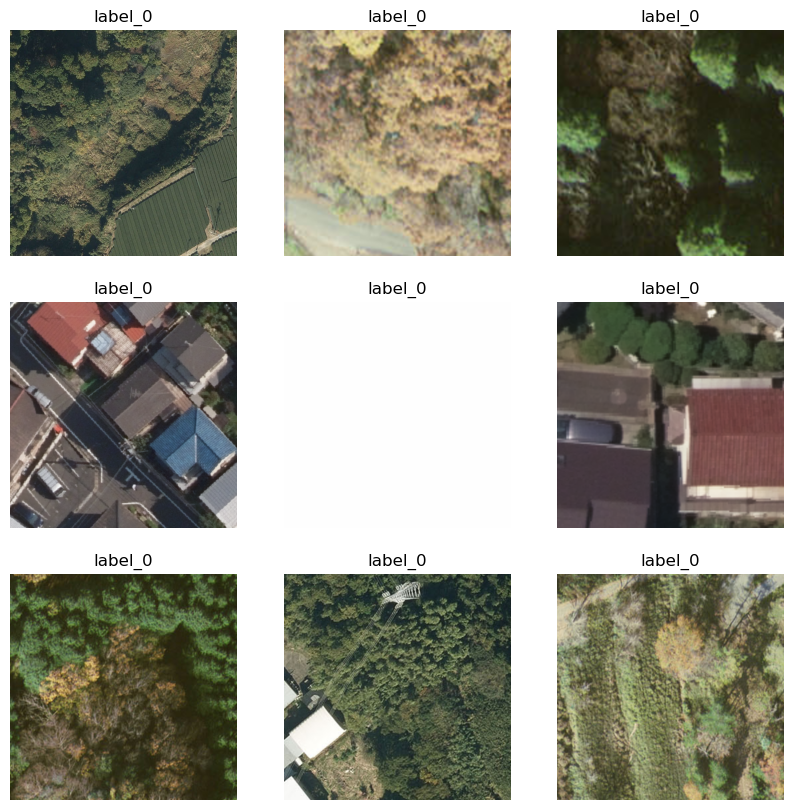

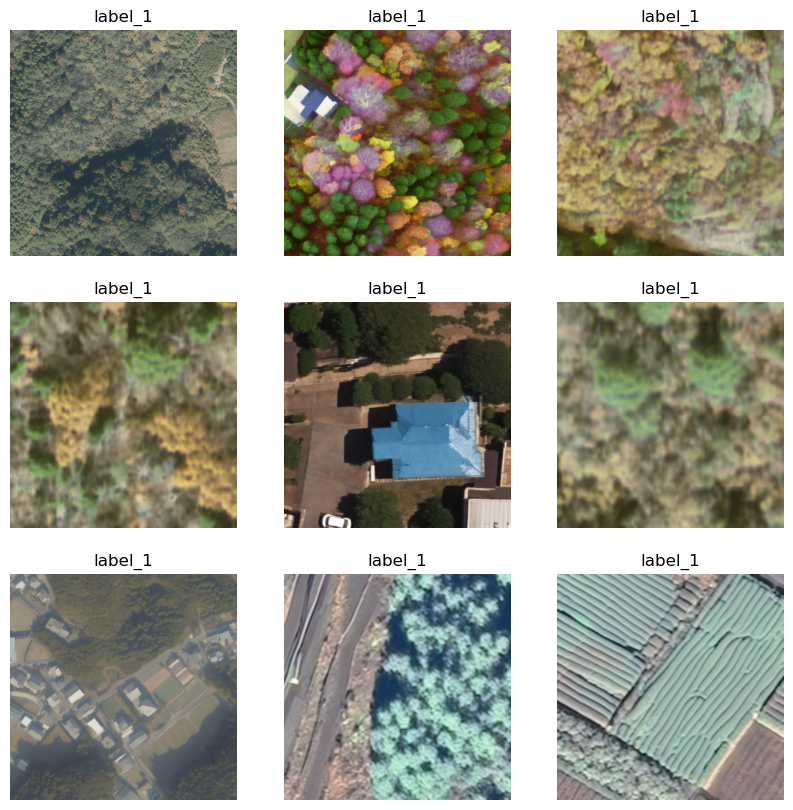

In [9]:
# Get image paths for label 0 and 1
image_paths_0 = df[df['label'] == 0]['name'].values
image_paths_1 = df[df['label'] == 1]['name'].values

# Function to display images
def display_images(image_paths, title):
    plt.figure(figsize=(10,10))
    for i in range(9):  # display 9 images
        plt.subplot(3,3,i+1)
        img = Image.open(image_paths[i])
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

# Display images for label 0 and 1
display_images('../data/train_1/'+ image_paths_0, 'label_0')
display_images('../data/train_1/'+ image_paths_1, 'label_1')

## 画像が欠損しているデータもあり

In [10]:
df.groupby('label')['name'].count()

label
0    2500
1    2500
Name: name, dtype: int64

# ベースモデル

## test実行

In [49]:
# train_1/配下のデータをtrain/validを分割する
## Load labels from csv
df = pd.read_csv('../data/train_1.csv', header=None, names=['name', 'label'])
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

train_transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Define a custom dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.df.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

## Load datasets
train_data = CustomImageDataset(train_df, '../data/train_1/', transform=train_transforms)
valid_data = CustomImageDataset(valid_df, '../data/train_1/', transform=valid_transforms)

## Create dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)


# trainデータで学習
## Define the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # assuming binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
#         print(outputs.shape)
#         print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


## resnet34

In [11]:
# train_1/配下のデータをtrain/validを分割する
## Load labels from csv
df = pd.read_csv('../data/train_1.csv', header=None, names=['name', 'label'])
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

train_transforms = transforms.Compose([
    transforms.Resize(512),
#     transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(512),
#     transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Define a custom dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.df.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

## Load datasets
train_data = CustomImageDataset(train_df, '../data/train_1/', transform=train_transforms)
valid_data = CustomImageDataset(valid_df, '../data/train_1/', transform=valid_transforms)

## Create dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)


# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = torchvision.models.resnet34()
net.fc = nn.Linear(net.fc.in_features, 2) 

# Move the model to GPU if available
net = net.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [12]:
# validデータで精度評価
## Validate the network
correct = 0
total = 0
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the valid images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the valid images: 82 %


In [13]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx] 

In [14]:
# testデータでスコアリング
## Load test data
test_data = TestDataset(root_dir='../data/evaluation/', transform=valid_transforms)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
## Score the test data
predictions = []
with torch.no_grad():
    for data in test_loader:
        images, _ = data
        images = images.to(device)
        
        logits = net(images)
        probabilities = F.softmax(logits, dim=1)  # apply softmax to convert logits to probabilities
        predictions.extend(probabilities.tolist())  # convert PyTorch tensor to Python list




In [15]:
# submit用に整形
# Create a DataFrame with the image names and the probabilities
df_submission = pd.DataFrame({
    'image_name': [f'test_{i}.png' for i in range(len(predictions))],
    'probability': [probs[1] for probs in predictions]
})

# Write the DataFrame to a csv file
df_submission.to_csv('submission_2.csv', index=False,header=False)
